# BRUN0-NET

Breve introduzione ritardata sul modello BRUN0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import transformers
from random import shuffle
import seaborn as sns
import matplotlib.ticker as mtick
import re

dataset_path = "./dataset"
bert_path = f"{dataset_path}/bert"

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analisi del Dataset

Carico il dataset in memoria e ne stampo una breve anteprima

In [2]:
dataset = pd.read_csv(f'{dataset_path}/train.csv')
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


Controllo quanti `essey_id` compaiono nel dataset e quanti ne ho nella cartella `train`

In [3]:
unique_esseyid_dataset = dataset["essay_id"].unique()
esseyid_number = len(unique_esseyid_dataset)

real_esseyid_number = !ls {dataset_path}/train | wc -l

print(f"N Essey ID in dataset: {esseyid_number}")
print(f"N Essey ID in folder:  {real_esseyid_number[0]}")
# print(unique_esseyid_dataset)

N Essey ID in dataset: 4191
N Essey ID in folder:  4191


Vado a stampare la frequenza dei vari elementi delle colonne `discourse_type` e `discourse_effectiveness` per vedere quanto il dataset è sbilanciato

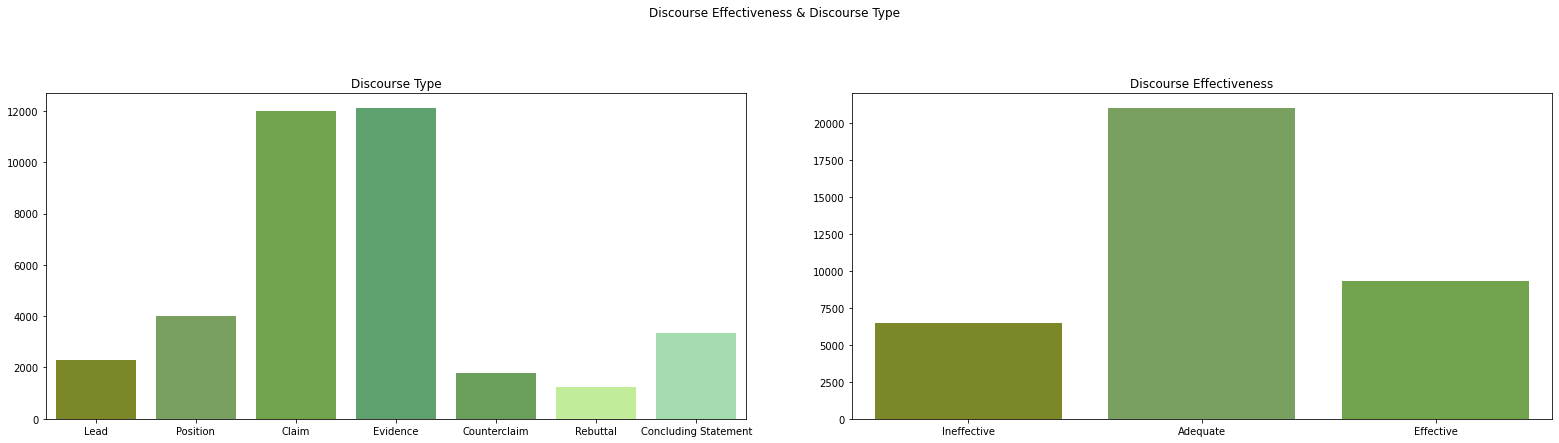

In [4]:
palette = ["xkcd:baby shit green", "xkcd:asparagus", "xkcd:nasty green", "xkcd:algae", "xkcd:fern", "xkcd:pistachio", "xkcd:hospital green"]

fig, axes = plt.subplots(1, 2, figsize=(27, 6))

# discoruse type
labels = dataset['discourse_type'].unique()
sns.countplot(
    x="discourse_type", 
    data=dataset, 
    linewidth=1.25, 
    alpha=1, 
    ax=axes[0], 
    zorder=2, 
    order=labels, 
    palette=palette
)
axes[0].set(xlabel=None, ylabel=None, title="Discourse Type")

# discoruse effectiveness
labels = ["Ineffective", "Adequate", "Effective"]
sns.countplot(
    x="discourse_effectiveness", 
    data=dataset, 
    linewidth=1.25, 
    alpha=1, 
    ax=axes[1], 
    zorder=2, 
    order=labels, 
    palette=palette
)
axes[1].set(xlabel=None, ylabel=None, title="Discourse Effectiveness")

fig.suptitle('Discourse Effectiveness & Discourse Type', y=1.08)
fig.subplots_adjust(
    wspace=0.15, 
    #left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.4
)

plt.show()

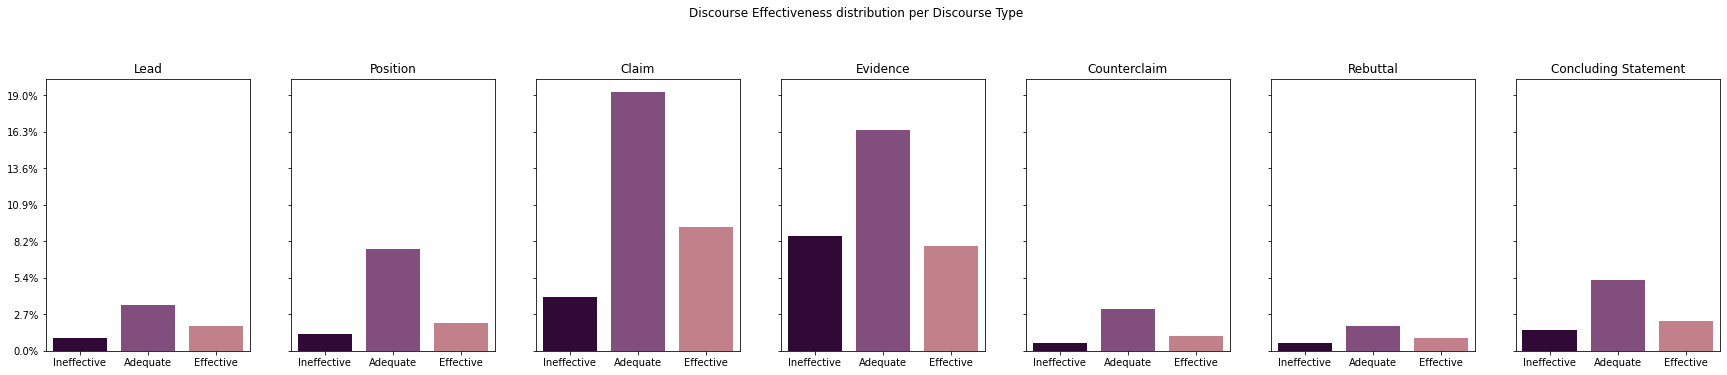

In [5]:
palette = ["xkcd:deep purple", "xkcd:light eggplant", "xkcd:ugly pink"]

discourse_types = dataset.discourse_type.unique()
# labels = dataset["discourse_effectiveness"].unique()
discourse_id = len(dataset.discourse_id)
fig, axes = plt.subplots(1, len(discourse_types), sharex='col', sharey='row', figsize=(30, 5))
for i, discourse_type in enumerate(discourse_types):
    ax = axes[i]
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(discourse_id))

    filtered_df = dataset[dataset.discourse_type == discourse_type]
    
    sns.countplot(
        x="discourse_effectiveness", 
        data=filtered_df, 
        linewidth=1.25, 
        alpha=1, 
        ax=ax, 
        zorder=2, 
        order=labels, 
        palette=palette
    )
    ax.set(xlabel=None, ylabel=None, title=discourse_type)

fig.suptitle('Discourse Effectiveness distribution per Discourse Type', y=1.08)
plt.show()

Possiamo notare dai precedenti grafici che il dataset risulta molto **sbilanciato**:

- Nella colonna `discourse_effectiveness`, ho tantissimi elementi che appartengono alla classe `Adequate` e pochissimi per le altre 2 classi `Effective`e `Ineffective`
- Nella colonna `discourse_type`, ho tantissimi testi che appartengono alle tipologia `Evidence` e `Claim` ma estremamente pochi per tutte le altre



Vado a stampare, per ogni tipologia di testo, quanti di questi risultano `Adequate`, `Effective` e `Ineffective`.

In [6]:
# WITH STOPWORDS

chars_count = []
words_count = []
punctuation_count = []

for text in dataset["discourse_text"]:
    chars = len(text)
    punctuation = len(re.findall(r"[^\w\s ']", text))
    
    chars_count.append(chars)
    words_count.append(len(re.split(r'\b\W+\b', text)))
    punctuation_count.append(punctuation)

    
dataset["discourse_chars_count"] = pd.Series(chars_count)
dataset["discourse_words_count"] = pd.Series(words_count)
dataset["discourse_punctuation_count"] = pd.Series(punctuation_count)

for cls in dataset["discourse_effectiveness"].unique():
    chars_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_chars_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    words_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_words_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_count_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_punctuation_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_percent_mean = round(punctuation_count_mean / chars_mean * 100, 3)

    print(f'{cls}: {chars_mean} c / {words_mean} w / {punctuation_count_mean} p / {punctuation_percent_mean} p%')

Adequate: 193 c / 36 w / 3 p / 1.554 p%
Ineffective: 266 c / 49 w / 4 p / 1.504 p%
Effective: 364 c / 64 w / 6 p / 1.648 p%


In [7]:
# NO STOPWORDS
import nltk
from nltk.corpus import stopwords

# if missing stopwords file (?)
# nltk.download('stopwords')

stops = set(stopwords.words("english"))
stops_regex = r""
for stop in stops:
    stops_regex += fr"\b{stop}\b|"

stops_regex = stops_regex[: -1]

no_stops = []
chars_count = []
words_count = []
punctuation_count = []

for text in dataset["discourse_text"]:
    # short form to long form: i'm -> i am
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    # removing stopwrods
    nostops_text = re.sub(stops_regex, '', text)

    # splitted = re.split(r'\b\W+\b', text)
    # nostops_text = [w for w in splitted if not w.lower() in stops]
    # nostops_text = " ".join(nostops_text)

    chars = len(nostops_text)
    words = len(re.split(r'\b\W+\b', nostops_text))
    punctuation = len(re.findall(r"[^\w\s ']", nostops_text))
    
    no_stops.append(nostops_text)
    chars_count.append(chars)
    words_count.append(words)
    punctuation_count.append(punctuation)

dataset["discourse_nostops"] = pd.Series(no_stops)
dataset["discourse_chars_count"] = pd.Series(chars_count)
dataset["discourse_words_count"] = pd.Series(words_count)
dataset["discourse_punctuation_count"] = pd.Series(punctuation_count)

for cls in dataset["discourse_effectiveness"].unique():
    chars_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_chars_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    words_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_words_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_count_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_punctuation_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_percent_mean = round(punctuation_count_mean / chars_mean * 100, 3)

    print(f'{cls}: {chars_mean} c / {words_mean} w / {punctuation_count_mean} p / {punctuation_percent_mean} p%')

Adequate: 144 c / 19 w / 3 p / 2.083 p%
Ineffective: 199 c / 26 w / 4 p / 2.01 p%
Effective: 276 c / 34 w / 6 p / 2.174 p%


### Upsampling

In [6]:
from sklearn.utils import resample

In [17]:
df_minority = dataset[dataset.discourse_effectiveness=='Ineffective']
# df_minority = df[df.balance==1]

df_minority_upsampled = resample(
    df_minority, 
    replace=True,     # sample with replacement
    n_samples=6000,    # to match majority class
    random_state=123
) # reproducible results

In [18]:
df_minority_upsampled

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
18193,afeee6cc6dc7,33475A71956C,Here at our school it would be great to have t...,Concluding Statement,Ineffective
17514,c96bbbb455ab,2BB4BFD96ABE,The Electoral College consists of 538 electors...,Evidence,Ineffective
7099,04a67f5318f1,806100760821,"In Vauban, Germany residents given up their ca...",Evidence,Ineffective
20939,ad7e85ee98be,58621C689C7B,because the only way that I would do that one ...,Evidence,Ineffective
27583,71d653c6b3f2,B15AF429027A,The dont need away getting nowhere if its onli...,Claim,Ineffective
...,...,...,...,...,...
17817,0db7f2956de9,2F19735DD6EC,"Last, we came together an said we dont know",Concluding Statement,Ineffective
21764,cd71dc68d867,63C74FF7DB27,first reason is not the same to take on school.,Claim,Ineffective
31156,442a32ab6a28,E5B1751B2798,We should keep the Electoral College because i...,Position,Ineffective
17730,3010484f5883,2DFFB145BE07,"""The Electoral College consists of 538 elector...",Evidence,Ineffective


In [19]:
df_upsampled = pd.concat([dataset, df_minority_upsampled])

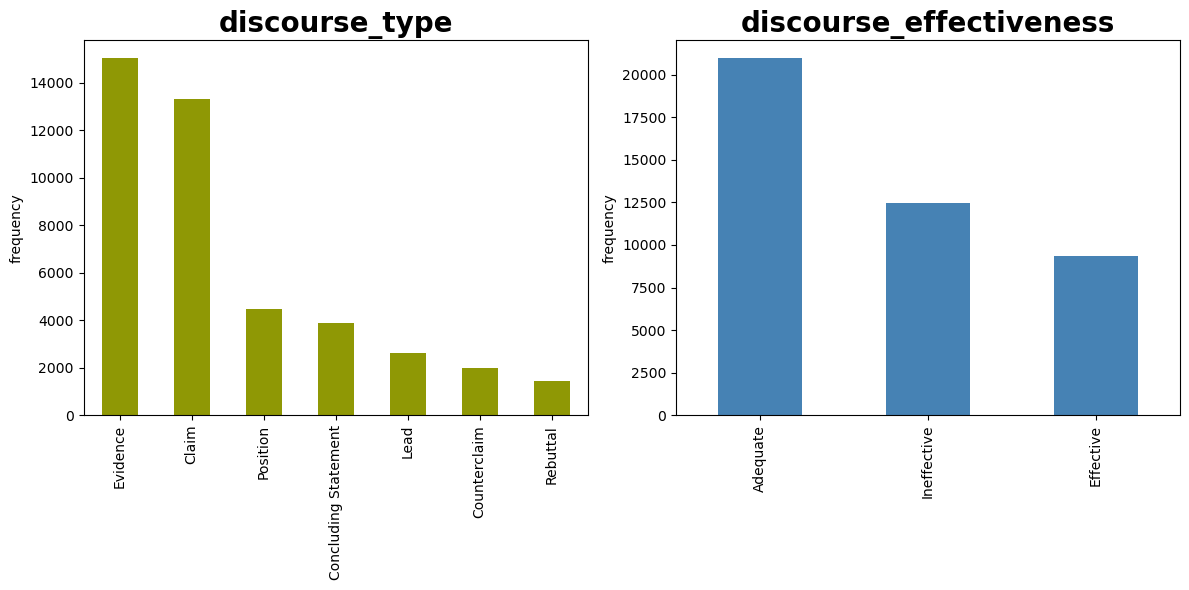

In [20]:
def _plot_column_count(ax, dataset_column: str, xlabel: str, ylabel: str, colors=["blue"], kind='bar'):
    """
        Funzione per stampare quanti elementi diversi sono presenti all'interno di una colonna
        del dataset.
    """

    ax.set_title(dataset_column, fontsize=20, fontweight='bold')
    
    test = df_upsampled[dataset_column].value_counts().plot(
        ax=ax, 
        kind=kind, 
        xlabel=xlabel, 
        ylabel=ylabel, 
        color=colors
        )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), dpi=100)

_plot_column_count(ax1, 'discourse_type', '', 'frequency', ["xkcd:baby poop green"])
_plot_column_count(ax2, 'discourse_effectiveness', '', 'frequency', ["steelblue"])

fig.tight_layout()
plt.show()

In [37]:
print(df_upsampled[df_upsampled.discourse_effectiveness=='Ineffective']['discourse_id'].count())
print(len(df_upsampled[df_upsampled.discourse_effectiveness=='Ineffective']['discourse_id'].unique()))

print(dataset[dataset.discourse_effectiveness=='Ineffective']['discourse_id'].count())


12462
6462
6462


In [34]:
df_upsampled[df_upsampled.discourse_effectiveness=='Ineffective']



,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
23,a44371d6abc5,00BD97EA4041,The process begins when the computer puts toge...,Evidence,Ineffective
31,235278a2c6d7,00C6E82FE5BA,"Ads can be good for promotion of products, but...",Claim,Ineffective
37,7a01d9cb379a,013B9AA6B9DB,well it is not.,Rebuttal,Ineffective
55,94d217778be6,015BB7DA58EE,Well to start off the technology has decoded t...,Claim,Ineffective
...,...,...,...,...,...
17817,0db7f2956de9,2F19735DD6EC,"Last, we came together an said we dont know",Concluding Statement,Ineffective
21764,cd71dc68d867,63C74FF7DB27,first reason is not the same to take on school.,Claim,Ineffective
31156,442a32ab6a28,E5B1751B2798,We should keep the Electoral College because i...,Position,Ineffective
17730,3010484f5883,2DFFB145BE07,"""The Electoral College consists of 538 elector...",Evidence,Ineffective


## PreProcessing Dataset

Inizio la preparazione del staset andando a convertire le classi della colonna `discourse_effectiveness` in valori univoci (`int`) per poterli poi passare al modello con più semplicità.

In [8]:
def words_to_indices(words: pd.Series) -> list:
    """
        Questa funzione va ad assegnare un ID unico (parte da 0) ad ogni elemento della serice (colonna)
        che gli viene passato.

        E.g.
            input:  pd.Series(['a', 'b', 'a', 'c', 'd', 'c'])
            output: [(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd')]
    """

    enumeration = enumerate(words.unique()) # prende ogni elemento 1 sola volta
                                            # funzione unique() fa si che ad ogni run l'ordine della parole sia lo stesso
                                            # a differenza di set()
    
    return list(enumeration)


In [9]:
# assegna degli indici univoci alle classi della colonna discourse_effectiveness
effectiveness_label_index = words_to_indices(dataset["discourse_effectiveness"])

# creo le due nuove colonne
dataset["effectiveness_label"] = dataset['discourse_effectiveness']

# rimpiazzo gli elementi dalle nuove colonne con quelli corretti (gli indici numerici)
for new_value, old_value in effectiveness_label_index:
    dataset["effectiveness_label"].replace(old_value, new_value, inplace=True)

Definisco la configurazione base per il modello di Embedding **BERT** ed altri parametri per il dataset

In [10]:
# Bert Configuration
# TODO: spostare in un posto migliore
AUTO = tf.data.experimental.AUTOTUNE
EPOCHS = 3
BATCH_SIZE = 12
# ------------ # 

MAX_LEN = 256

In [11]:
# Definizione del modello di encoding con Bert
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids      = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(
            text, 
            max_length=max_len, 
            truncation=True, 
            padding='max_length',
            add_special_tokens=True
            )
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [12]:
# tokenizer = transformers.BertTokenizer.from_pretrained(bert_path)   # si ottiene il tokenizer Bert da un modello pre allenato
# tokenizer.save_pretrained('./prova/') # Salva il tokenizer creato in locale

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [13]:
sep = tokenizer.sep_token
sep

'[SEP]'

Vado ad aggiungre una nuova colonna al dataset dove andrò a concatenare il dipo del discorso ed il discorso stesso (unisco le colonne `discourse_type` e `discourse_text`) tramite un carattere **separatore** che BERT sarà in grado di riconoscere.

In [14]:
# genera una nuova colonna includendo 'discourse_type' all'interno del testo da analizzare
dataset['inputs'] = dataset.discourse_type + sep + dataset.discourse_text
dataset['inputs_nostops'] = dataset.discourse_type + sep + dataset.discourse_nostops
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_chars_count,discourse_words_count,discourse_punctuation_count,discourse_nostops,effectiveness_label,inputs,inputs_nostops
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,220,28,6,"Hi, Isaac, going writing face Mars...",0,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","Lead[SEP]Hi, Isaac, going writing f..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,147,21,3,"On perspective, I think face natural land...",0,"Position[SEP]On my perspective, I think that t...","Position[SEP]On perspective, I think face ..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,67,9,0,I think face natural landform life Ma...,0,Claim[SEP]I think that the face is a natural l...,Claim[SEP]I think face natural landform ...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,266,36,11,"If life Mars, would know . The reason I t...",0,"Evidence[SEP]If life was on Mars, we would kno...","Evidence[SEP]If life Mars, would know . Th..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,64,8,1,People thought face formed alieans thoug...,0,Counterclaim[SEP]People thought that the face ...,Counterclaim[SEP]People thought face formed...


Suddivido il dataset in una parte di **training** e una parte di **valdation**

**TODO:** unire con sep discoryuse_type e testo potrebbe far perdere significativita' al discoruse_type

In [15]:
""" # suddivide il dataset in training e validation
x_train, x_test, y_train, y_test = train_test_split(dataset["inputs"], dataset["effectiveness_label"], test_size=.2, shuffle=True)


print(f"x_train shape: {x_train.shape}")
print(f"x_test  shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

print('\n')

print("Esempio: ")
print(f'x: {x_train[0]}')
print(f'y: {y_train[0]}') """


' # suddivide il dataset in training e validation\nx_train, x_test, y_train, y_test = train_test_split(dataset["inputs"], dataset["effectiveness_label"], test_size=.2, shuffle=True)\n\n\nprint(f"x_train shape: {x_train.shape}")\nprint(f"x_test  shape: {x_test.shape}")\nprint(f"y_train shape: {y_train.shape}")\nprint(f"y_test  shape: {y_test.shape}")\n\nprint(\'\n\')\n\nprint("Esempio: ")\nprint(f\'x: {x_train[0]}\')\nprint(f\'y: {y_train[0]}\') '

Vado ad applicare BERT all'input per codificarlo in modo tale da essere passato al modello

In [16]:
from sklearn.model_selection import GroupShuffleSplit

# WITH STOPWORDS
X = dataset[["essay_id", "inputs", "inputs_nostops"]]
y= dataset["effectiveness_label"]

gs = GroupShuffleSplit(n_splits=3, test_size=.2, random_state=420)
train_ix, test_ix = next(gs.split(X, y, groups=X.essay_id))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_test = X.loc[test_ix]
y_test = y.loc[test_ix]

x_train = X_train["inputs"]
x_test = X_test["inputs"]

x_train_nostops = X_train["inputs_nostops"]
x_test_nostops = X_test["inputs_nostops"]


In [17]:
print(x_train[0])
print(x_train_nostops[0])
print(y_train[0])

Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. 
Lead[SEP]Hi,    Isaac,    going   writing    face  Mars   natural landform     life  Mars  made . The story    NASA took  picture  Mars   face  seen   planet. NASA    know   landform  created  life  Mars,       natural landform. 
0


In [18]:
# WITH STOPWORDS
x_train = bert_encode(x_train.astype(str), tokenizer)
x_test = bert_encode(x_test.astype(str), tokenizer)

y_train = y_train.values
y_test = y_test.values

# NO STOPWORDS
x_train_nostops = bert_encode(x_train_nostops.astype(str), tokenizer)
x_test_nostops = bert_encode(x_test_nostops.astype(str), tokenizer)

y_train_nostops = y_train
y_test_nostops = y_test

Vado a creare i dataset finali di training e validation tramite le API di tensorflow

## Modelo Bello Bello

In [19]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Flatten, Input, Conv2D, Conv3D, MaxPooling2D, MaxPooling1D, Reshape, Conv1D
from tensorflow.keras.models import Model
from transformers import TFAutoModelForMaskedLM, TFBertModel, TFAutoModel
from keras import backend as K

2022-06-30 09:54:15.872387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 09:54:15.892238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 09:54:15.892427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 09:54:15.893135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Scrivo una funzione che mi aiuta ad allenare e testare i varo modelli che creerò per poter scegliere il migliore

In [20]:
def train_and_plot(model_builder: callable, model_version: str, batch_size=BATCH_SIZE, epochs=30, patience=10, steps_per_epoch=100, remove_stopwards=False):    
    K.clear_session()
    
    model = model_builder()
    model.summary()

    keras.utils.plot_model(model, f"./BRUN0-Net-{model_version}.png") # salva la foto del modello

    # select the dataset with or without stoprowds
    if remove_stopwards:
        train = x_train_nostops
        test = x_test_nostops
        print('no stops')
    else:
        train = x_train
        test = x_test
        print('stop')

    # dataset
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(AUTO)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices((test, y_test))
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )

    model_filepath = f'BRUN0-Net-{model_version}.h5'
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
    save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1) # Saves the best version of the model to disk (as measured on the validation data set)

    history = model.fit(
        train_dataset,
        validation_data=test_dataset, 
        epochs=epochs, 
        verbose=True, 
        steps_per_epoch=steps_per_epoch,
        callbacks=[es, save_best]
    )

    # save history object
    history_dict = history.history
    json.dump(history_dict, open(f'./history_save-{model_version}.bk', 'w'))

    # reload history object
    # history_dict = json.load(open('./history_save.bk', 'r'))

    model.save(model_filepath)

    # stampo grafico accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # stampo grafico loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Model Alpha $\alpha$

Tramite le API di tesnorflow e Keras e sfruttando il paradigma (??) Funzionale, vado a definire il modello.
Utilizzo il paradigma funzionale perchè è l'unico che permette di avere molteplici input e per ognuno la possibilità di passarlo ad un diverso layer.

In [32]:
def build_model(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = (TFAutoModelForMaskedLM.from_pretrained("bert-base-cased"))
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # MIDDEL LAYER
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # CLASSIFIER
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model


' model = build_model()\nmodel.summary() '

Mostro una rappresentazione grafica del modello

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


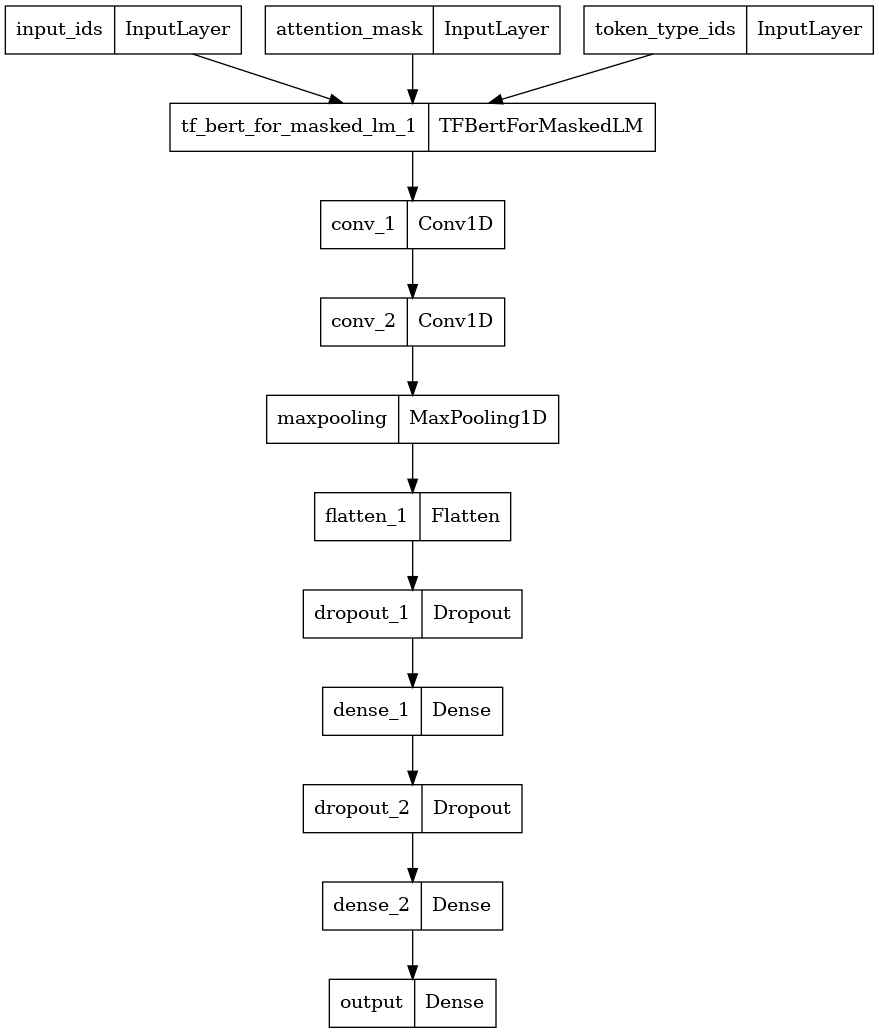

In [21]:
# keras.utils.plot_model(model, "./BRUN0-Net.png") # evita di salvare la foto 

Alleno il modello

In [ ]:
train_and_plot(build_model, 'alpha')

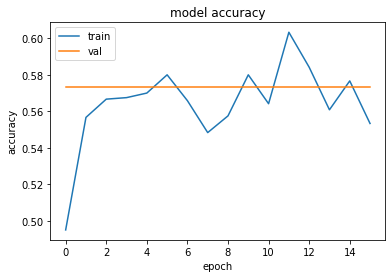

In [31]:
""" plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() """

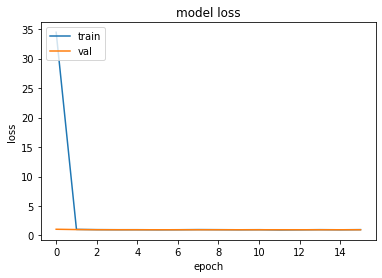

In [32]:
""" plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() """

### Model Beta $\beta$

In [19]:
def beta_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = (TFAutoModelForMaskedLM.from_pretrained("bert-base-cased"))
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # MIDDEL LAYER
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # CLASSIFIER
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

In [ ]:
train_and_plot(beta_model_builder, 'beta', batch_size=8)

### Model Gamma $\gamma$

In [14]:
def gamma_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = (TFAutoModelForMaskedLM.from_pretrained("bert-base-cased"))
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # CLASSIFIER
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

In [ ]:
train_and_plot(gamma_model_builder, 'gamma', batch_size=8)

### Model Delta $\delta$

In [14]:
def delta_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = (TFAutoModelForMaskedLM.from_pretrained("bert-base-cased"))
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # MIDDEL LAYER
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # OUTPUT
    drop_out = Dropout(.1)(lstm_2)
    
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

2022-06-22 14:44:38.921918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:44:38.927005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:44:38.927238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:44:38.927995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_for_masked_lm (TFBertF  TFMaskedLMOutput(lo  108340804  ['input_ids[0][0]',              
 orMaskedLM)                    ss=None, logits=(No               'attention_mask[0][0]',     

2022-06-22 14:44:51.511705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.5775
Epoch 1: val_loss improved from inf to 0.99391, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 140s 1s/step - loss: 1.0056 - accuracy: 0.5775 - val_loss: 0.9939 - val_accuracy: 0.5632
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.5908
Epoch 2: val_loss improved from 0.99391 to 0.98523, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 131s 1s/step - loss: 0.9672 - accuracy: 0.5908 - val_loss: 0.9852 - val_accuracy: 0.5632
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.0011 - accuracy: 0.5450
Epoch 3: val_loss improved from 0.98523 to 0.98357, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 130s 1s/step - loss: 1.0011 - accuracy: 0.5450 - val_loss: 0.9836 - val_accuracy: 0.5632
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 

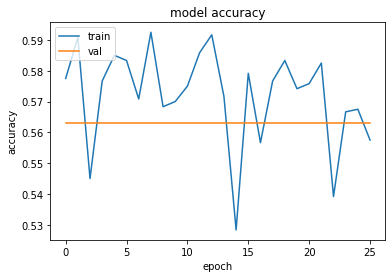

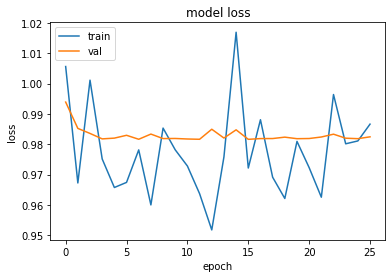

In [15]:
train_and_plot(delta_model_builder, 'delta')

### Model Epsilon $\epsilon$

In [16]:
def epsilon_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = (TFAutoModelForMaskedLM.from_pretrained("bert-base-cased"))
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # MIDDEL LAYER
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # OUTPUT
    flatten = Flatten()(lstm_2)
    
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_for_masked_lm (TFBertF  TFMaskedLMOutput(lo  108340804  ['input_ids[0][0]',              
 orMaskedLM)                    ss=None, logits=(No               'attention_mask[0][0]',     

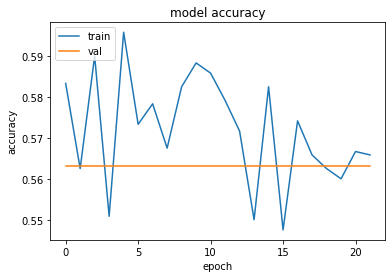

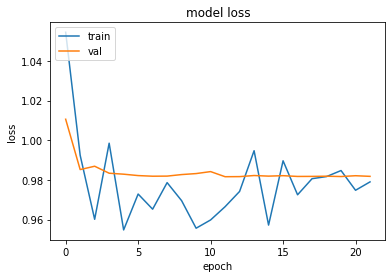

In [17]:
train_and_plot(epsilon_model_builder, 'epsilon')

### Model Zeta $\zeta$

In [14]:
def zeta_model_builder(max_len=MAX_LEN):  
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(3, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

2022-06-23 07:43:43.681626: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.5567
Epoch 1: val_loss improved from inf to 0.80712, saving model to BRUN0-Net-zeta.h5
100/100 [==============================] - 122s 1s/step - loss: 0.9581 - accuracy: 0.5567 - val_loss: 0.8071 - val_accuracy: 0.6374
Epoch 2/30
100/100 [======================

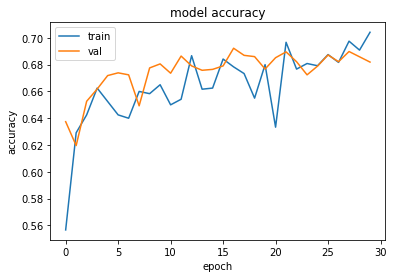

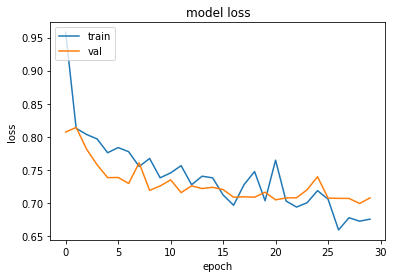

In [15]:
train_and_plot(zeta_model_builder, 'zeta')

## Modelli con BERT Model fatto bene

<hr>

### Model Alpha Plus $\alpha^+$

In [ ]:
def alphaplus_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # MIDDEL LAYER
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # CLASSIFIER
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model


In [ ]:
train_and_plot(alphaplus_model_builder, 'alpha_plus')

### Model Beta Plus $\beta^+$

In [14]:
def betaplus_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # MIDDEL LAYER
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # CLASSIFIER
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

2022-06-23 09:09:23.592509: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-23 09:09:34.203506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.5417
Epoch 1: val_loss improved from inf to 0.96612, saving model to BRUN0-Net-beta_plus.h5
100/100 [==============================] - 126s 1s/step - loss: 1.0529 - accuracy: 0.5417 - val_loss: 0.9661 - val_accuracy: 0.5860
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.5417
Epoch 2: val_loss did not improve from 0.96612
100/100 [==============================] - 115s 1s/step - loss: 1.0196 - accuracy: 0.5417 - val_loss: 0.9771 - val_accuracy: 0.5860
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.5817
Epoch 3: val_loss did not improve from 0.96612
100/100 [==============================] - 115s 1s/step - loss: 0.9904 - accuracy: 0.5817 - val_loss: 0.9841 - val_accuracy: 0.5860
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.5842
Epoch 4: val_loss improved from 0.96612 to 0.96417

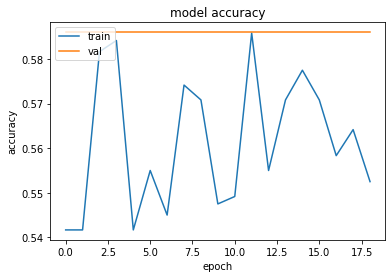

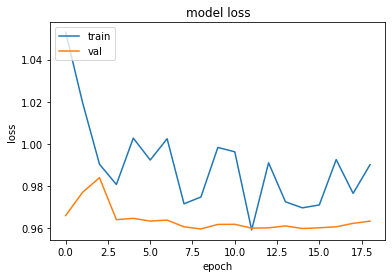

In [15]:
train_and_plot(betaplus_model_builder, 'beta_plus')

### Model Gamma Plus $\gamma^+$

In [ ]:
def gammaplus_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # CLASSIFIER
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

In [ ]:
train_and_plot(gammaplus_model_builder, 'gamma_plus')

### Model Delta Plus $\delta^+$

In [ ]:
def deltaplus_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # MIDDEL LAYER
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # OUTPUT
    drop_out = Dropout(.1)(lstm_2)
    
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

In [ ]:
train_and_plot(deltaplus_model_builder, 'delta_plus')

### Model Epsilon Plus $\epsilon^+$

In [16]:
def epsilonplus_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # MIDDEL LAYER
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # OUTPUT
    flatten = Flatten()(lstm_2)
    
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.4733
Epoch 1: val_loss improved from inf to 1.04429, saving model to BRUN0-Net-epsilon_plus.h5
100/100 [==============================] - 124s 1s/step - loss: 1.0816 - accuracy: 0.4733 - val_loss: 1.0443 - val_accuracy: 0.5860
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.5583
Epoch 2: val_loss improved from 1.04429 to 1.00368, saving model to BRUN0-Net-epsilon_plus.h5
100/100 [==============================] - 115s 1s/step - loss: 1.0271 - accuracy: 0.5583 - val_loss: 1.0037 - val_accuracy: 0.5860
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.5642
Epoch 3: val_loss improved from 1.00368 to 0.98184, saving model to BRUN0-Net-epsilon_plus.h5
100/100 [==============================] - 116s 1s/step - loss: 1.0066 - accuracy: 0.5642 - val_loss: 0.9818 - val_accuracy: 0.5860
Epoch 4/30
100/100 [=============================

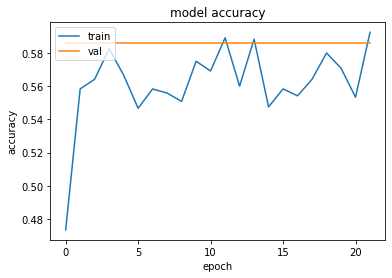

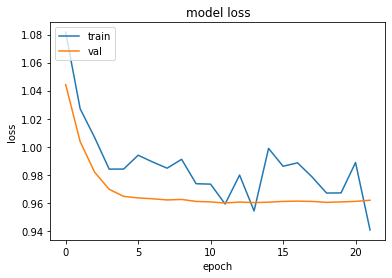

In [17]:
train_and_plot(epsilonplus_model_builder, 'epsilon_plus')

## Modelli con Adam Classe

In [21]:
from keras.optimizers import Adam

### Model Alpha Star $\alpha^*$

In [23]:
def alphastar_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # MIDDEL LAYER
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # CLASSIFIER
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model


2022-06-23 11:08:54.538554: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-23 11:09:04.891690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.6008
Epoch 1: val_loss improved from inf to 0.87459, saving model to BRUN0-Net-alpha_star.h5
100/100 [==============================] - 121s 1s/step - loss: 0.9383 - accuracy: 0.6008 - val_loss: 0.8746 - val_accuracy: 0.6174
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.8726 - accuracy: 0.6008
Epoch 2: val_loss improved from 0.87459 to 0.80715, saving model to BRUN0-Net-alpha_star.h5
100/100 [==============================] - 111s 1s/step - loss: 0.8726 - accuracy: 0.6008 - val_loss: 0.8072 - val_accuracy: 0.6353
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.6317
Epoch 3: val_loss improved from 0.80715 to 0.78223, saving model to BRUN0-Net-alpha_star.h5
100/100 [==============================] - 112s 1s/step - loss: 0.8108 - accuracy: 0.6317 - val_loss: 0.7822 - val_accuracy: 0.6518
Epoch 4/30
100/100 [==============================] - E

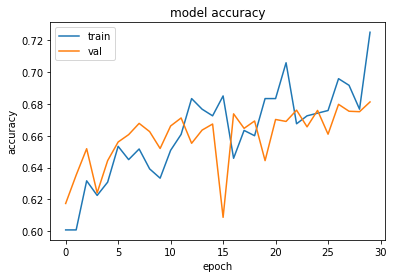

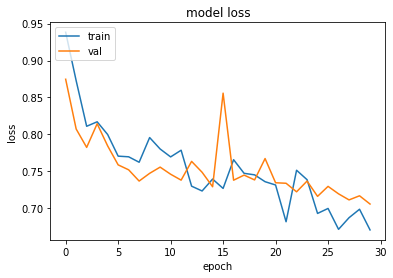

In [16]:
train_and_plot(alphastar_model_builder, 'alpha_star')

### Model Beta Star $\beta^*$

In [15]:
def betastar_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # MIDDEL LAYER
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # CLASSIFIER
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

Downloading: 100%|██████████| 502M/502M [00:08<00:00, 62.7MB/s] 
2022-06-23 17:50:17.369363: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you c

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-23 17:50:27.983959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.0113 - accuracy: 0.4767
Epoch 1: val_loss improved from inf to 0.95581, saving model to BRUN0-Net-beta_star.h5
100/100 [==============================] - 123s 1s/step - loss: 1.0113 - accuracy: 0.4767 - val_loss: 0.9558 - val_accuracy: 0.5745
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.5842
Epoch 2: val_loss improved from 0.95581 to 0.93548, saving model to BRUN0-Net-beta_star.h5
100/100 [==============================] - 113s 1s/step - loss: 0.9645 - accuracy: 0.5842 - val_loss: 0.9355 - val_accuracy: 0.5959
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.6192
Epoch 3: val_loss improved from 0.93548 to 0.89514, saving model to BRUN0-Net-beta_star.h5
100/100 [==============================] - 112s 1s/step - loss: 0.9281 - accuracy: 0.6192 - val_loss: 0.8951 - val_accuracy: 0.6389
Epoch 4/30
100/100 [==============================] - ETA:

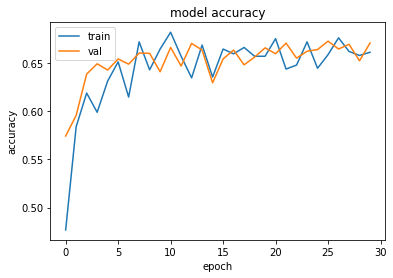

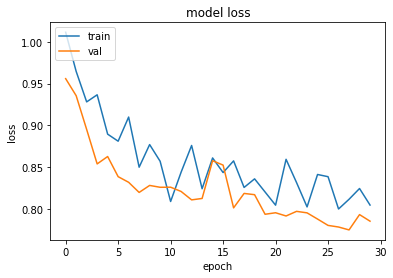

In [16]:
train_and_plot(betastar_model_builder, 'beta_star')

### Model Gamma Star $\gamma^*$

In [18]:
def gammastar_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # CLASSIFIER
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

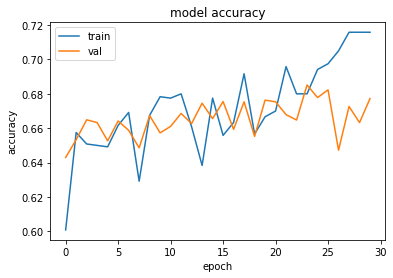

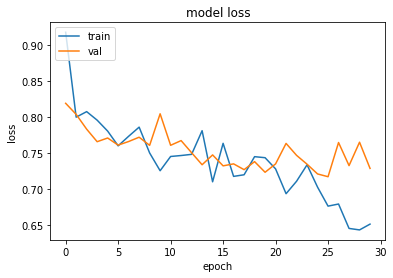

In [19]:
train_and_plot(gammastar_model_builder, 'gamma_star')

### Model Delta Star $\delta^*$

In [16]:
def deltastar_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # MIDDEL LAYER
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # OUTPUT
    drop_out = Dropout(.1)(lstm_2)
    
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

2022-06-24 07:44:53.482170: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-24 07:45:04.789692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 0.9457 - accuracy: 0.5908
Epoch 1: val_loss improved from inf to 0.92380, saving model to BRUN0-Net-delta_star.h5
100/100 [==============================] - 123s 1s/step - loss: 0.9457 - accuracy: 0.5908 - val_loss: 0.9238 - val_accuracy: 0.5955
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.6125
Epoch 2: val_loss improved from 0.92380 to 0.88779, saving model to BRUN0-Net-delta_star.h5
100/100 [==============================] - 113s 1s/step - loss: 0.9007 - accuracy: 0.6125 - val_loss: 0.8878 - val_accuracy: 0.6276
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.8826 - accuracy: 0.6275
Epoch 3: val_loss improved from 0.88779 to 0.85581, saving model to BRUN0-Net-delta_star.h5
100/100 [==============================] - 112s 1s/step - loss: 0.8826 - accuracy: 0.6275 - val_loss: 0.8558 - val_accuracy: 0.6585
Epoch 4/30
100/100 [==============================] - E

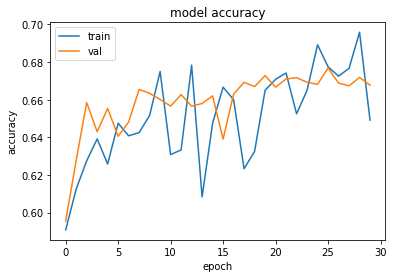

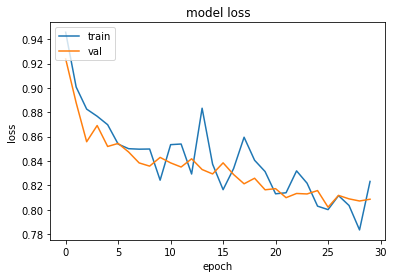

In [17]:
train_and_plot(deltastar_model_builder, 'delta_star')

### Model Epsilon Star $\epsilon^*$

In [17]:
def epsilonstar_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # MIDDEL LAYER
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # OUTPUT
    flatten = Flatten()(lstm_2)
    
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.5742
Epoch 1: val_loss improved from inf to 0.97622, saving model to BRUN0-Net-epsilon_star.h5
100/100 [==============================] - 121s 1s/step - loss: 0.9896 - accuracy: 0.5742 - val_loss: 0.9762 - val_accuracy: 0.5765
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9624 - accuracy: 0.5883
Epoch 2: val_loss improved from 0.97622 to 0.97111, saving model to BRUN0-Net-epsilon_star.h5
100/100 [==============================] - 112s 1s/step - loss: 0.9624 - accuracy: 0.5883 - val_loss: 0.9711 - val_accuracy: 0.5787
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.9809 - accuracy: 0.5608
Epoch 3: val_loss improved from 0.97111 to 0.96623, saving model to BRUN0-Net-epsilon_star.h5
100/100 [==============================] - 112s 1s/step - loss: 0.9809 - accuracy: 0.5608 - val_loss: 0.9662 - val_accuracy: 0.5819
Epoch 4/30
100/100 [=============================

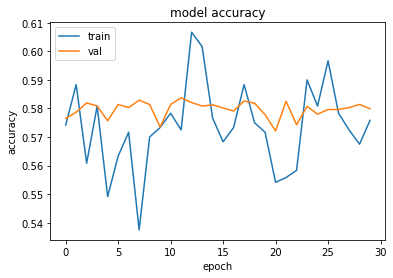

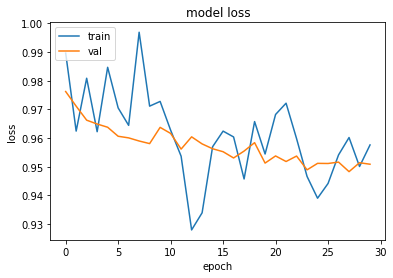

In [18]:
train_and_plot(epsilonstar_model_builder, 'epsilon_star')

### Model Zeta Star $\zeta^*$

In [22]:
def zetastar_model_builder(max_len=MAX_LEN):  
    # INPUTS  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT WORLD EMBEDDING
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # CLASSIFIER
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

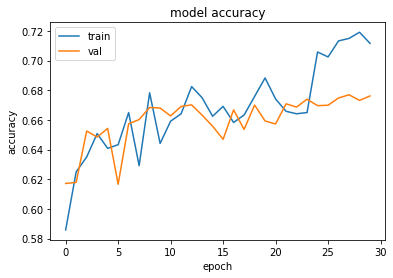

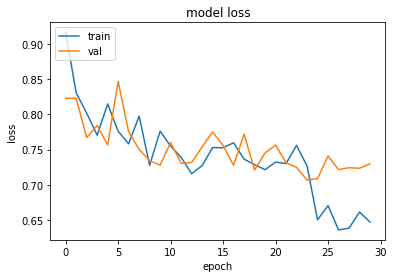

In [18]:
train_and_plot(zetastar_model_builder, 'zeta_star')

## Riallenamento con Dataset Giusto

### Model Alpha Star $\alpha*$ stops and nostops

2022-06-28 16:55:15.970029: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-28 16:55:26.805167: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.0137 - accuracy: 0.5017
Epoch 1: val_loss improved from inf to 0.90175, saving model to BRUN0-Net-alpha_hat_withstops.h5
100/100 [==============================] - 121s 1s/step - loss: 1.0137 - accuracy: 0.5017 - val_loss: 0.9017 - val_accuracy: 0.6113
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.8561 - accuracy: 0.5992
Epoch 2: val_loss improved from 0.90175 to 0.82091, saving model to BRUN0-Net-alpha_hat_withstops.h5
100/100 [==============================] - 111s 1s/step - loss: 0.8561 - accuracy: 0.5992 - val_loss: 0.8209 - val_accuracy: 0.6378
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.6700
Epoch 3: val_loss improved from 0.82091 to 0.79261, saving model to BRUN0-Net-alpha_hat_withstops.h5
100/100 [==============================] - 111s 1s/step - loss: 0.7539 - accuracy: 0.6700 - val_loss: 0.7926 - val_accuracy: 0.6520
Epoch 4/30
100/100 [========

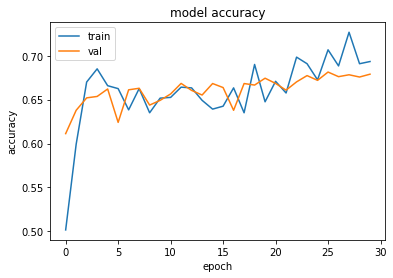

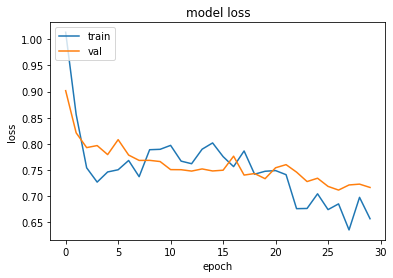

In [22]:
# with stopwrds with dataset splitted in a consistent way
train_and_plot(alphastar_model_builder, 'alpha_star_withstops')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

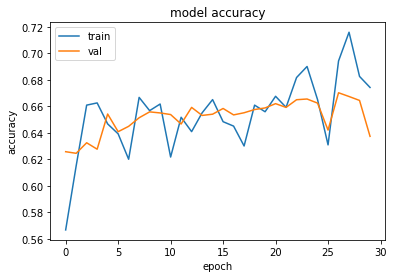

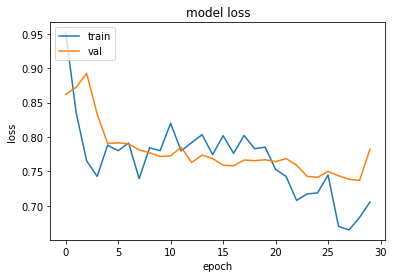

In [23]:
# with stopwrds with dataset splitted in a consistent way
train_and_plot(alphastar_model_builder, 'alpha_star_nostops', remove_stopwards=True)

### Model Zeta Star $\zeta*$ stops and nostops

2022-06-29 09:25:20.855022: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

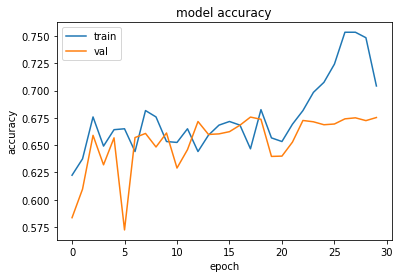

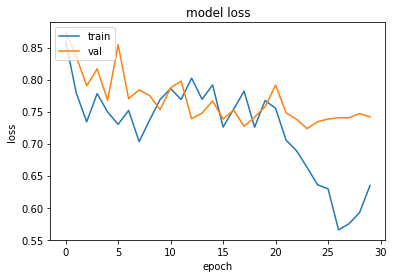

In [23]:
# with stopwrds with dataset splitted in a consistent way
train_and_plot(zetastar_model_builder, 'zeta_star_withstops')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

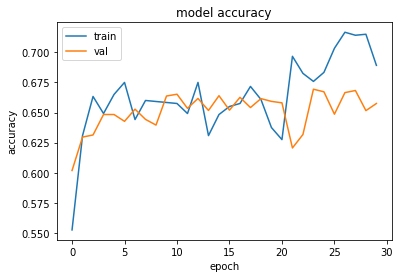

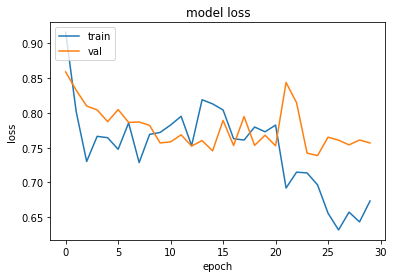

In [24]:
# no stopwrds with dataset splitted in a consistent way
train_and_plot(zetastar_model_builder, 'zeta_star_nostops', remove_stopwards=True)

### Model Alpha Star 60 $\alpha^{*60}$

2022-06-30 09:54:42.519628: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-30 09:54:52.821439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.0094 - accuracy: 0.5025
Epoch 1: val_loss improved from inf to 0.90360, saving model to BRUN0-Net-alpha_star_60_withstops.h5
100/100 [==============================] - 121s 1s/step - loss: 1.0094 - accuracy: 0.5025 - val_loss: 0.9036 - val_accuracy: 0.6047
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 0.8522 - accuracy: 0.6017
Epoch 2: val_loss improved from 0.90360 to 0.83535, saving model to BRUN0-Net-alpha_star_60_withstops.h5
100/100 [==============================] - 112s 1s/step - loss: 0.8522 - accuracy: 0.6017 - val_loss: 0.8353 - val_accuracy: 0.6301
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 0.7558 - accuracy: 0.6608
Epoch 3: val_loss improved from 0.83535 to 0.79211, saving model to BRUN0-Net-alpha_star_60_withstops.h5
100/100 [==============================] - 112s 1s/step - loss: 0.7558 - accuracy: 0.6608 - val_loss: 0.7921 - val_accuracy: 0.6454
Epoch 4/60
100/1

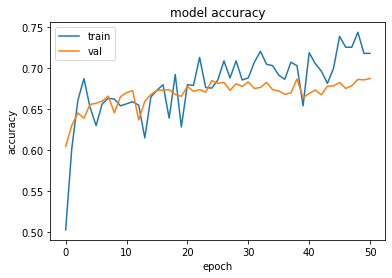

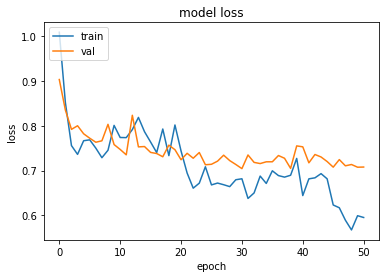

In [24]:
train_and_plot(alphastar_model_builder, 'alpha_star_60_withstops', epochs=60, patience=20)